In [27]:
import pandas as pd
%matplotlib inline

![DKB Logo](http://upload.wikimedia.org/wikipedia/commons/thumb/f/f0/Deutsche-Kreditbank-AG-Logo.svg/500px-Deutsche-Kreditbank-AG-Logo.svg.png)

In [28]:
knr = '1808150815' # type in your KNr here!
kst = 1000.0 # EUR zu Beginn

In [29]:
data = pd.read_csv(knr+'.csv', index_col='Buchungstag',
                   header=4, sep=';', quoting=1, parse_dates=True,
                   encoding='latin-1', dayfirst=True)

In [30]:
#data.head(5)

### Fix European Thousands and Comma String Problem

In [31]:
data['Betrag (EUR)'] = data['Betrag (EUR)'].str.replace('.','')
data['Betrag (EUR)'] = data['Betrag (EUR)'].str.replace(',','.')
data['Betrag (EUR)'] = data['Betrag (EUR)'].astype('float')

In [32]:
# Anon the data for public
#import random
#data['Betrag (EUR)'] = [-50+random.random()*200 for rv in range(len(data['Betrag (EUR)']))]
#data[u'Auftraggeber / Begünstigter'] = ['Empf/Sender '+str(i) for i in range(len(data['Betrag (EUR)']))]

### Rename some things

In [33]:
data[u'Auftraggeber / Begünstigter'].replace('DKB AG', 'DKB Broker', inplace=True)
data[u'Auftraggeber / Begünstigter'].replace('DKB VISACARD', 'Bar', inplace=True)

### Inverse Dataframe to have first day first

In [34]:
data = data.iloc[::-1]

In [35]:
fr = data.index[0]
to = data.index[-1]

### Cumulative Sum over values plus starting balance

In [36]:
data['Kontostand (EUR)'] = data['Betrag (EUR)'].cumsum()+kst

### Linear Trend

In [37]:
from scipy.stats import linregress
def fit_line(x, y):
    """Return slope, intercept of best fit line."""
    slope, intercept, r, p, stderr = linregress(x, y)
    return slope, intercept

In [38]:
slope, intercept = fit_line( (data.index - data.index[0]).days, data['Kontostand (EUR)'].values)

In [39]:
print('You gain %.2fEUR per day.' % slope)

You gain 30.07EUR per day.


In [40]:
data['Kontostand (EUR) linear'] = (data.index - data.index[0]).days * slope + intercept

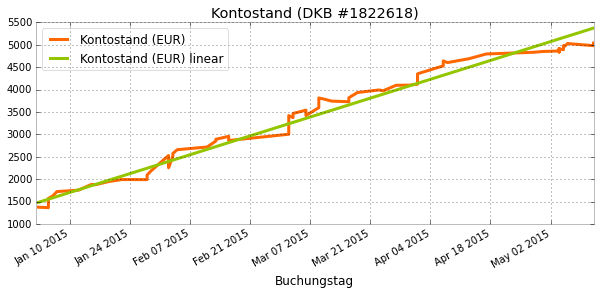

In [41]:
data[['Kontostand (EUR)', 'Kontostand (EUR) linear']].plot(title='Kontostand (DKB #%s)' % knr, figsize=(10,4))

### Broke or a Million on

In [42]:
from datetime import timedelta
if slope < 0:
    brokedate = data.index[0] + timedelta(days=((0.0-intercept) / slope))
    print('Pleite am %i.%i.%i' % (brokedate.day, brokedate.month, brokedate.year))
else:
    try:
        goal = 1000000.0 # million
        milliondate = data.index[0] + timedelta(days=((goal-intercept) / slope))
        print(u'Millionär am %i.%i.%i' % (milliondate.day, milliondate.month, milliondate.year))
    except:
        print(u'Wahrscheinlich wirst du niemals Millionär!')

Millionär am 4.12.2105


## Who's doin' it?

In [43]:
empfgroup = data.groupby(u'Auftraggeber / Begünstigter')['Betrag (EUR)'].sum()

In [44]:
empfgroup.sort()

In [45]:
# Short the names
empfgroup.index = [str(i)[:30] for i in empfgroup.index]

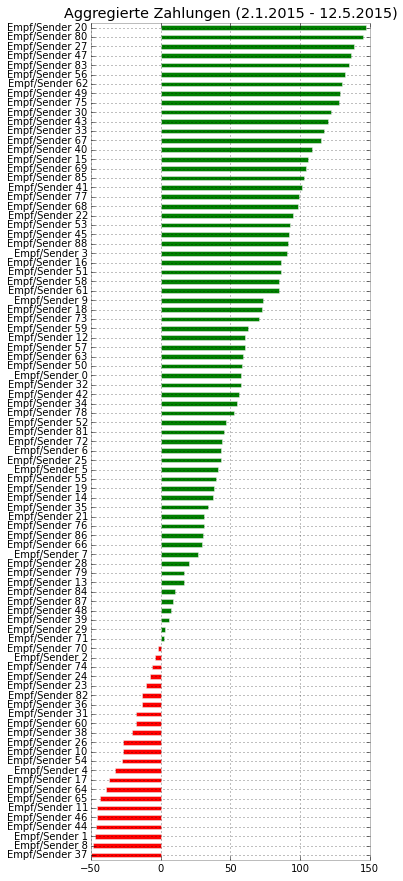

In [46]:
empfgroup.plot(kind='barh', figsize=(5,15),
               color=['g' if empfgroup.values[i]>0 else 'r' for i in range(len(empfgroup.values))],
               title=u'Aggregierte Zahlungen (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year))